#### Generalizing the VMC to arbitrary number of parameters
This now takes in a wavefunction with an arbitrary number of parameters, and then instead of 
generating a plot to find the minimum average energy, it uses the gradient descent algorithm
to find the minimum.

by changing the `num_params` variable, we vary the number of parameters that the method uses. We then define `sym_psi` which defines the trial wavefunction, in terms of `x` and the parameters. We then run a gradient descent optimizer to find the minimum value of the energy. 

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import random
import sympy as sym
from IPython.display import clear_output

m = 1
omega = 1
lam = .01
hbar = 1
num_params = 9
true_energy = .5 + .75*lam
# define all the symbolic variables and expressions
x = sym.Symbol('x')
p = [sym.symbols('a%d' % i) for i in range(num_params)]
# the wavefunction
sym_psi = p[0]*sym.exp(-p[1]*(x + p[2])**2) + p[3] * sym.exp(-p[4]*(x+p[5])**2) + p[6] * sym.exp(-p[7]*(x+p[8])**2)

sym_ddpsi = sym.diff(sym.diff(sym_psi, x), x)
# the partial derivatives of the log of psi
partials = [sym.diff(sym.log(sym_psi), p[i]) for i in range(num_params)]
# functions that compute the gradient vector terms
logpsis = [sym.lambdify([x,p], partials[i]) for i in range(num_params)]

# define the potential
def V(x_inp):
    return 1/2 * m * omega**2 * x_inp**2 + lam * x_inp**4

# define the wavefunction
psi = sym.lambdify([x,p], sym_psi)

# define the second derivative w.r.t x of the wavefunction
ddpsi = sym.lambdify([x,p], sym_ddpsi)

# defines the gradient of the log of psi wrt to the parameters
def grad_log_psi(x_inp, params):
    # this will return a vector of length len(params)
    grad = np.zeros(len(params))
    # now add in the derivatives with respect to each variable
    for i in range(num_params):
        grad[i] = logpsis[i](x_inp, params)
    return grad

# define the Hamiltonian applied to psi
def Hpsi(x_inp, params):
    return V(x_inp)*psi(x_inp,params) - hbar**2/(2*m) * ddpsi(x_inp, params)

# define the function that samples the probability distribution
# uses the metropolis sampling method
def sample(params, num_samples):
    outputs = []
    # pick the start point
    x_t = 0
    for t in range(num_samples):
        x_prime = x_t + random.uniform(-1,1)
        
        if (random.uniform(0,1) < psi(x_prime, params)**2/psi(x_t, params)**2):
            x_t = x_prime
        outputs.append(x_t)
    return outputs

# define a function that computes the average energy
def avg_energy(params, N):
    # get N sampled points
    samples = sample(params, N)
    # apply the function to every point
    applied = [(1/psi(x_a, params) * Hpsi(x_a, params)) for x_a in samples]
    return 1/N * sum(applied)

# computes the gradient with respect to the parameters of the energy
def gradient(params, N):
    samples = sample(params, N)
    # now compute the 3 different averages
    energy_exp = 1/N * sum([(1/psi(x_a, params) * Hpsi(x_a, params)) for x_a in samples])
    print("Average Energy: " + str(energy_exp))
    gradlogpsi_exp = 1/N * sum([grad_log_psi(x_a, params) for x_a in samples], 0)
    both_exp = 1/N * sum([(1/psi(x_a, params) * grad_log_psi(x_a, params) * Hpsi(x_a, params)) for x_a in samples], 0)
    return (2 * both_exp - 2 * energy_exp * gradlogpsi_exp)

# write a gradient descent optimizer for the average energy
def grad_opt(start_params, learning_rate, max_iterations=1000, tolerance=.001, N=10**4):
    # pick the starting position
    params = start_params
    hist = []
    # iterate until we run out of iterations or less than tolerance
    for it in range(max_iterations):
        clear_output(wait=True)
        # compute the gradient at that point
        diff = learning_rate * gradient(params, N) 
        if all((abs(val) < tolerance) for val in diff):
            print("All under tolerance")
            return params
        # make a step in the direction opposite the gradient
        params = params - diff
        # print(params)
        hist.append(params)
    return params

In [10]:
start = [.5,.5,.5,0,.6,.1,.5,.5,.5]

optd = grad_opt(start, .1, N=10**4)

Average Energy: 0.7442698051901383
All under tolerance


[0.49991709 0.9070504  0.00208343 0.1095109  0.71190464 0.01861402
 0.49991709 0.9070504  0.00208343]
Minimized Energy: 0.7539793210282202
True GS Energy: 1.025
Percent Difference: 26.441041850905343


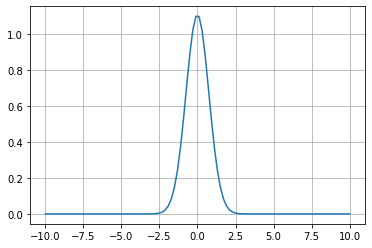

In [11]:
#plot the wavefunction
print(optd)
x_vals = np.linspace(-10,10,100)
y = [psi(x_a, optd) for x_a in x_vals]
v = [V(x_a) for x_a in x_vals]
comp_avg = avg_energy(optd, 10**5)
print("Minimized Energy: "+str(comp_avg))
print("True GS Energy: "+ str(true_energy))
print("Percent Difference: " + str(100*(true_energy - comp_avg)/true_energy))
plt.plot(x_vals,y)
#plt.plot(x_vals,v)
plt.grid()
plt.show()